# 03 Train VAE
The `vae` module of SPARROW performs cell type inference via a latent representation $Z$, in both supervised and unsupervised modes. In the supervised mode, $Z$ coembeds the expression matrix $X$ of the SRT data with the expression matrix $X'$ of the scRNA-seq data from analogous tissues. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import dask.dataframe as dd
import os,sys
import scanpy as sc
import torch
import umap
import json
from sklearn.preprocessing import LabelEncoder
import pyro.optim
from pyro.infer import SVI, config_enumerate, Trace_ELBO

sys.path.append("/home/jupyter/tools/")
import SPARROW

/home/jupyter/envs/spatial2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set the subdirectory in which you will save model outputs

my_model_dir = "test_model"
directory = f"/home/jupyter/sparrow_demo/{my_model_dir}"
if not os.path.exists (directory):
    os.makedirs(directory)

os.chdir(directory)

## orthogonal scRNA-seq is available

In [4]:
# Load the scRNA-seq anndata
import scanpy as sc
scRNA_seq=sc.read_h5ad("/home/jupyter/tools/SPARROW/testdata/tonsil_scRNA.h5ad")



In [5]:
scRNA_seq

AnnData object with n_obs × n_vars = 253950 × 224
    obs: 'celltypes'
    var: 'genes'

In [6]:
# Load the parquet file previously created according to notebook 02
parquet_dir = "/home/jupyter/tools/SPARROW/testdata/tonsil_EXP409/"
obj = SPARROW.preprocessing.ingest.read_parquet(f"{parquet_dir}",n_meta_col=6)
obj

In [7]:
obj.parquet

,center_x,center_y,min_x,min_y,max_x,max_y,CD4,TNFRSF17,IL4R,LGALS2,PIK3IP1,IL2RB,GZMB,PAG1,RELB,EBI3,TGFB1,NKG7,COL1A1,AICDA,KLRB1,PASK,TNFAIP3,TGFB3,TNFSF10,SOX4,SOX9,TNFSF14,CCR7,FGL2,LIF,DNAJB1,SDC1,BLK,IL36A,CCND2,TNFRSF13B,CDH1,PDGFRB,ZBTB32,IL1B,GNLY,CAPG,MCM6,CSTA,STAT3,CXCL9,ZAP70,CD27,IRF8,SPIB,EAF2,CCNA2,GZMA,EBP,DOK2,LCN2,CARS1,ARID5B,PDE3B,THY1,CSF1R,CCNB2,TNFRSF13C,S100B,STAT5B,CTLA4,STAT6,CD3D,CXXC5,IL7R,TMEM154,RRM2,CXCL10,XCR1,VEGFB,IRF3,MAL,CDC20,CD7,CD6,GIMAP7,CD55,PER1,SWAP70,DCTPP1,RASSF1,RFLNB,CSF1,MX2,KRT6A,IL3RA,TBX1,PRR5,PRELP,HLA-DQA1,E2F1,CXCL12,FCER2,IKZF3,CD8A,ATF7IP2,ITGAL,BCL11B,STMN1,APP,PAX5,MS4A7,CCL20,PLCG2,STAT1,CD47,APOBEC3C,CR1,TAGAP,TULP4,MAPKAPK2,STX7,FCGR2B,SLAMF7,PYHIN1,FCRL1,FCRL3,MKI67,PRDM1,STMN3,GBP5,VEGFA,MMP9,PLAU,PRF1,UGCG,RCAN3,KLF4,HLA-DMA,TNFSF13B,FOXP3,PPP1R10,SPI1,CYBB,TPD52,TNFRSF4,TNFRSF18,DDX58,LY86,IRF4,IL6ST,IL33,TMEM156,TIGIT,POU2F2,IGHD,CD8B,SP140,CD247,CCDC50,CD79B,ABLIM1,POU2AF1,MAF,TCF7,CPVL,CFP,IRF7,TPST2,SELENOM,CD14,CSF2RB,IRF1,RELA,BCL6,CEBPD,CUL3,ZEB2,IL1R1,ALDH2,HLA-DMB,LTA,TOP2A,GFI1,COL17A1,BANK1,CCNE1,TNF,IKZF2,NELL2,SYNE1,MBNL1,ORAI2,TNFRSF1B,CLIC3,KLF6,LINC00861,LINC00926,LEF1,LYN,IDO1,MYBL1,MYC,MAML2,IL32,BIRC3,JAML,CTSH,SESN3,BACH2,PLD4,NUDT4,FKBP11,TCL1A,PRKCH,STAT2,GNG2,TSPAN3,PECAM1,CLEC10A,ITGAE,DYNLL2,PITPNC1,FOSB,STAT5A,CDCA3,CCL5,TRAC,MARCKS,MYO1F,FOXP1,MUC1,EBF1,TCF4
npartitions=2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [8]:
#check the parquet file is loaded properly
obj._genes

Index(['CD4', 'TNFRSF17', 'IL4R', 'LGALS2', 'PIK3IP1', 'IL2RB', 'GZMB', 'PAG1',
       'RELB', 'EBI3',
       ...
       'STAT5A', 'CDCA3', 'CCL5', 'TRAC', 'MARCKS', 'MYO1F', 'FOXP1', 'MUC1',
       'EBF1', 'TCF4'],
      dtype='object', length=224)

In [93]:
#first select training gene features. The command below selectes gene features that are expressed in at least 5% of all cells,
#the feature variance being above 0.1
features_to_train = SPARROW.VAE.vae.feature_selection(obj,genes=None,min_perc=0.05,var=1)


In [94]:
#now find the intersection between selected gene features from SRT and those in scRNA-seq
scrna_genes = set(np.unique(scRNA_seq.var['genes']))
selected_features=set(features_to_train).intersection(scrna_genes)
len(selected_features)

172

In [95]:
#train test split 
X_train,X_test,X_prime_train,X_prime_test,label_train,label_test = SPARROW.VAE.vae.train_test_split(
    obj,
    scRNA_seq,
    label='celltypes',
    use_xprime_labels=True,
    selected_features=selected_features,
    train_perc=0.8,
    random_seed=42,
    output_path = directory
)

In [96]:
X_train.shape, X_test.shape, X_prime_train.shape, X_prime_test.shape, len(label_train), len(label_test)

((708724, 172), (177181, 172), (203160, 172), (50790, 172), 203160, 50790)

In [97]:
#Initialize VAE model with specific dimensions for input ( X_train.shape[1]) ,hidden layers ([200,100,80]), and logit layers ([50,40,14]). The last dimension of logits layers need to be the same as the number of cell types defined in accompanying scRNA-seq data.
len(np.unique(scRNA_seq.obs))

14

In [98]:
#set up model architecture. Layer dimensions and layer numbers are both tunable parameters.
VAEmodel=SPARROW.VAE.vae.vae(X_train.shape[1],[160,84],[64,48,14])

# Provide a name for saving the model
model_output_name = "sparrow_demo_vae_model"

# Set up the optimizer for training

AdamArgs = {'lr': 2e-3, 'weight_decay': 1e-5}
optimizer = pyro.optim.Adam(AdamArgs)
svi = SVI(
    VAEmodel.model, 
    config_enumerate(VAEmodel.guide, "sequential", expand=True),
    optimizer, 
    loss=Trace_ELBO()
)

In [ ]:
# Begin training and monitor the loss. The loss is written to a log file with a user defined name.
SPARROW.VAE.vae.train(
    VAEmodel, svi, X_train.values, X_prime_train, label_train,
    num_epochs = 5,
    log_name = f"{directory}/training_{model_output_name}.log",
    write = False,  #we are not saving the model yet. If saving is desired, set write=True
) 



In [123]:
#Evaluate and apply the trained VAE model.
#note the model here is not trained to convergence; this is for demonstration only
VAEmodel.eval() # set the model to evaluation mode

with torch.no_grad():  # Disable gradient computation for inference
    # Obtain latent representations
    loc,_=VAEmodel.Encoder(torch.from_numpy(X_train.values).type(torch.float))
    locprime,_ = VAEmodel.Encoder(torch.from_numpy(X_prime_train).type(torch.float))
    
    # Generate logits from the latent representations
    logits,_=VAEmodel.Encoder_logits(loc)
    logitsprime,_=VAEmodel.Encoder_logits(locprime)
    

In [135]:
# Check prediction accuracy in percentage format:
print(f'Prediction accuracy for scRNA-seq labels is {100 * len(np.where(logitsprime.argmax(axis=1).numpy() == label_train)[0]) / len(locprime):.2f}%')


Prediction accuracy for scRNA-seq labels is 82.71%


In [140]:
def run_umap(input_array, n_neighbors=15, metric='euclidean', angular=True, random_state=16, metric_kwds=None):
    """
    Perform UMAP dimensionality reduction using precomputed nearest neighbors.
    
    Parameters:
    - input_array (np.ndarray): Input data array.
    - n_neighbors (int): Number of neighbors for UMAP.
    - metric (str): Distance metric to use for nearest neighbors.
    - angular (bool): Whether to use angular distance for tree-building.
    - random_state (int): Random seed for reproducibility.
    - metric_kwds (dict or None): Additional keyword arguments for the metric.

    Returns:
    - umap_model (umap.UMAP): Fitted UMAP model.
    - transformed_data (np.ndarray): Transformed data.
    """
    # Compute nearest neighbors
    knn_indices, knn_dists, rp_trees = umap.umap_.nearest_neighbors(
        input_array, 
        n_neighbors=n_neighbors, 
        metric=metric, 
        metric_kwds=metric_kwds, 
        angular=angular, 
        random_state=random_state
    )
    
    # Fit UMAP with precomputed nearest neighbors
    umap_model = umap.UMAP(
        precomputed_knn=(knn_indices, knn_dists, rp_trees),
        n_neighbors=n_neighbors,
        metric=metric,
        random_state=random_state
    ).fit(input_array)
    
    return umap_model, umap_model.transform(input_array)

# Randomly sample indices for two datasets
idx = np.random.permutation(np.arange(len(loc)))[:10000]
idx_prime = np.random.permutation(np.arange(len(locprime)))[:10000]

# Combine the sampled data and run UMAP
combined_data = np.concatenate((loc.numpy()[idx], locprime.numpy()[idx_prime]))
umap_fit, umap_transform = run_umap(combined_data)


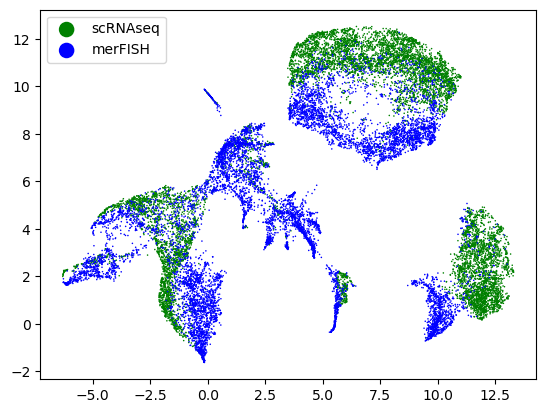

In [141]:
plt.scatter(*umap_transform[10000:].T,s=5,marker='.',edgecolors='none',c = 'g',label = 'scRNAseq')

plt.scatter(*umap_transform[:10000].T,s=5,marker='.',edgecolors='none', c = 'b',label = 'merFISH')

plt.legend(markerscale = 10)

In [ ]:
# Save the trained model once training stabilizes
VAEmodel.eval()
torch.save(VAEmodel.state_dict(), f"./training_{model_output_name}.json")

## orthogonal scRNA-seq is unavailable
First train the VAE model to obtain the latent representation $Z$, then cluster $Z$ based on kmeans or leiden to manually annotate cell types from the clustering outcome.

In [143]:
# Load the parquet file previously created according to notebook 02
parquet_dir = "/home/jupyter/sparrow_demo/test_parquet/"
obj = SPARROW.preprocessing.ingest.read_parquet(f"{parquet_dir}",n_meta_col=9)
obj

In [145]:
#train test split 
X_train,X_test,_,_,_,_ = SPARROW.VAE.vae.train_test_split(
    obj,
    selected_features=obj._genes_no_blank,
    train_perc=0.8,
    random_seed=42,
    output_path = directory
)

In [152]:
#set up model architecture. Layer dimensions and layer numbers are both tunable parameters.
VAEmodelunsupervised=SPARROW.VAE.vae.vae(X_train.shape[1],[160,84],[64,32,14])

# Provide a name for saving the model
model_output_name = "sparrow_demo_unsupervised_vae_model"

# Set up the optimizer for training

AdamArgs = {'lr': 2e-3, 'weight_decay': 1e-5}
optimizer = pyro.optim.Adam(AdamArgs)
svi = SVI(
    VAEmodelunsupervised.model, 
    config_enumerate(VAEmodelunsupervised.guide, "sequential", expand=True),
    optimizer, 
    loss=Trace_ELBO()
)

In [ ]:
# Begin training and monitor the loss. The loss is written to a log file with a user defined name.
SPARROW.VAE.vae.train(
    VAEmodelunsupervised, svi, X_train.values,
    num_epochs = 5,
    log_name = f"{directory}/training_{model_output_name}.log",
    write = False,  #we are not saving the model yet. If saving is desired, set write=True
) 


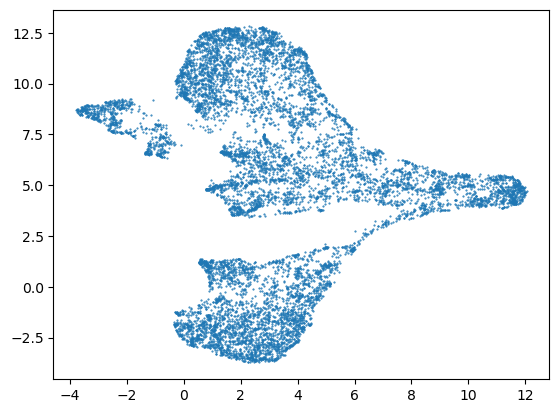

In [156]:
#Evaluate and apply the trained VAE model.
#note the model here is not trained to convergence; this is for demonstration only
VAEmodelunsupervised.eval()
with torch.no_grad():
    loc,scale=VAEmodelunsupervised.Encoder(torch.from_numpy(X_train.values).type(torch.float))
idx = np.random.permutation(np.arange(len(loc)))[:10000]
# Visualise Z in UMAP space 

umap_fit, umap_transform = run_umap(loc.numpy()[idx])
plt.scatter(*umap_transform.T,s = 1,marker='.')


### use Leiden to cluster on $Z$

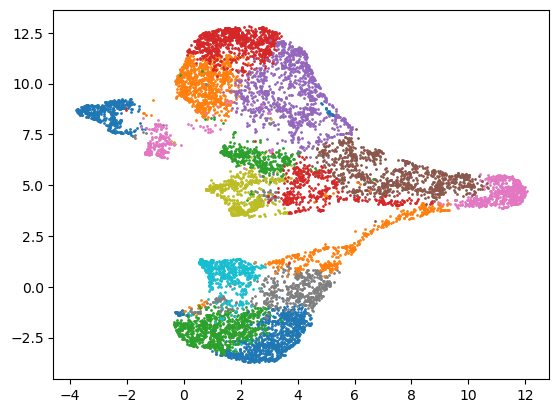

In [168]:
from sklearn.neighbors import kneighbors_graph
import igraph as ig
import leidenalg
import numpy as np

def leiden_clustering(Z, n_neighbors=5):
    """
    Perform Leiden clustering on the latent representation Z.
    
    Parameters:
    ----------
    Z : numpy.ndarray
        Latent representation from a VAE model encoder
    n_neighbors : int, optional, default=5
        Number of neighbors to consider for the k-NN graph.
    
    Returns:
    -------
    List[int]
        Membership indices indicating the cluster assignment for each node.
    """
    if not isinstance(Z, np.ndarray):
        raise ValueError("Input Z must be a numpy array.")
    if not isinstance(n_neighbors, int) or n_neighbors <= 0:
        raise ValueError("n_neighbors must be a positive integer.")
    
    # Create a k-NN graph from Z
    knn_graph = kneighbors_graph(Z, n_neighbors=n_neighbors, include_self=False, mode='connectivity')
    adjacency_matrix = knn_graph.toarray()
    
    # Symmetrize the adjacency matrix
    sym_adjacency_matrix = np.maximum(adjacency_matrix, adjacency_matrix.T)
    
    # Convert adjacency matrix to an igraph graph
    graph = ig.Graph.Adjacency((sym_adjacency_matrix > 0).tolist())
    graph.es['weight'] = sym_adjacency_matrix[sym_adjacency_matrix.nonzero()]  # Assign edge weights
    
    # Perform Leiden clustering
    partition = leidenalg.find_partition(graph, leidenalg.RBConfigurationVertexPartition, weights='weight', n_iterations=-1,
                                        resolution_parameter = 1)
    
    return partition.membership

#compute clusters on subsampled Z 
membership = leiden_clustering(loc.numpy()[idx])
membership = np.array(membership)
# Visualize the clusters on a UMAP projection

for i in range(max(membership)):
    plt.scatter(*umap_transform[membership == i].T,s = 1 )

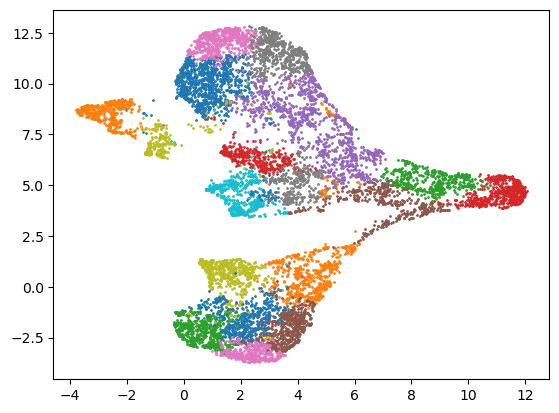

In [167]:
membership = np.array(membership)
for i in range(max(membership)):
    plt.scatter(*umap_transform[membership == i].T,s = 1 )